In [1]:
# ========== 0) 安装/导入 ==========
!pip -q install pillow

In [2]:
import io
import os
import json
import getpass
import requests
from PIL import Image
from IPython.display import display, HTML


if "GOOGLE_MAPS_API_KEY" not in os.environ:
    os.environ["GOOGLE_MAPS_API_KEY"] = getpass.getpass(
        "请输入你的 Google Maps API Key（不可见）: ")

API_KEY = os.environ["GOOGLE_MAPS_API_KEY"]


def text_search_places(query: str, region_code: str = "SG",
                       page_size: int = 5, with_photos: bool = True):
    fields = [
        "places.id",
        "places.displayName",
        "places.formattedAddress",
        "places.googleMapsUri",
    ]
    if with_photos:
        fields.append("places.photos")

    headers = {
        "Content-Type": "application/json",
        "X-Goog-FieldMask": ",".join(fields)  # FieldMask 仍需设置，否则 400
    }
    body = {
        "textQuery": query,
        "regionCode": region_code,
        "pageSize": page_size
    }
    # ✅ 把 key 放到 URL 查询参数
    r = requests.post(
        "https://places.googleapis.com/v1/places:searchText",
        headers=headers,
        params={"key": API_KEY},
        data=json.dumps(body)
    )
    r.raise_for_status()
    return r.json().get("places", [])

In [3]:
def fetch_photo_bytes(photo_name: str, max_w: int = 800, max_h: int = 800) -> bytes:
    """
    Place Photos (New):
    使用 photos.name + '/media' 获取图片数据（或 302 重定向到实际图片 URL）。
    参考：GET https://places.googleapis.com/v1/{NAME}/media?maxWidthPx=&maxHeightPx=&key=
    """
    # 注意：必须在 name 后拼接 /media
    url = f"https://places.googleapis.com/v1/{photo_name}/media"
    params = {
        "maxWidthPx": max_w,
        "maxHeightPx": max_h,
        "key": API_KEY
    }
    # 默认允许重定向；若想拿 JSON 里 photoUri，可加参数 skipHttpRedirect=true 再取 'photoUri'
    resp = requests.get(url, params=params, allow_redirects=True)
    resp.raise_for_status()
    return resp.content

In [4]:
def show_restaurant_photos(query: str,
                           region_code: str = "SG",
                           top_places: int = 1,
                           photos_per_place: int = 4,
                           max_w: int = 800,
                           max_h: int = 800):
    """
    搜索并展示餐厅图片：
      - 先 Text Search 找餐厅（携带 photos）
      - 再对每个 photo.name 调 Place Photos 取图
    """
    places = text_search_places(
        query, region_code=region_code, page_size=top_places, with_photos=True)
    if not places:
        display(HTML(f"<b>未找到结果：</b>{query}"))
        return

    for idx, p in enumerate(places, 1):
        title = p.get("displayName", {}).get("text", "Unknown")
        addr = p.get("formattedAddress", "")
        maps = p.get("googleMapsUri", "")
        display(HTML(f"<h3>{idx}. {title}</h3><div>{addr}</div>"
                     f"<div><a href='{maps}' target='_blank'>在 Google 地图打开</a></div>"))

        photos = p.get("photos", [])[:photos_per_place]
        if not photos:
            display(HTML("<i>此商家没有公开照片。</i>"))
            continue

        for ph in photos:
            name = ph["name"]  # e.g. places/PLACE_ID/photos/PHOTO_RESOURCE
            try:
                img_bytes = fetch_photo_bytes(name, max_w=max_w, max_h=max_h)
                img = Image.open(io.BytesIO(img_bytes))
                display(img)
            except Exception as e:
                display(HTML(f"<span style='color:#c00'>取图失败：{e}</span>"))
                continue

            # 署名（如有）
            atts = ph.get("authorAttributions", [])
            if atts:
                parts = []
                for a in atts:
                    dn = a.get("displayName", "")
                    uri = a.get("uri", "")
                    parts.append(
                        f"<a href='{uri}' target='_blank'>{dn}</a>" if uri else dn)
                display(
                    HTML(f"<small>Photo credit: {', '.join(parts)}</small>"))

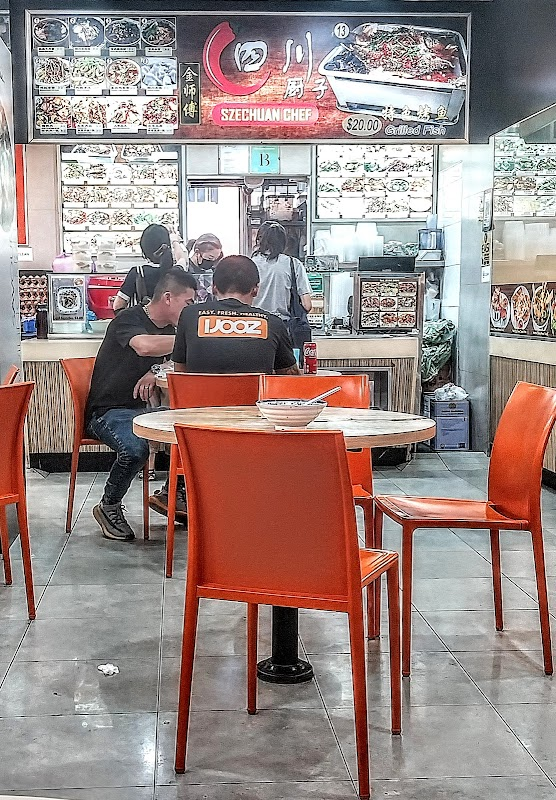

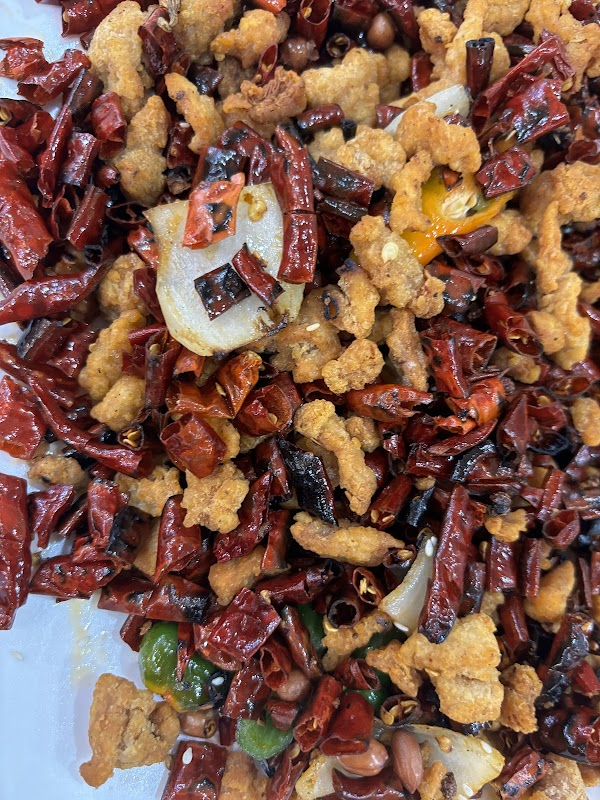

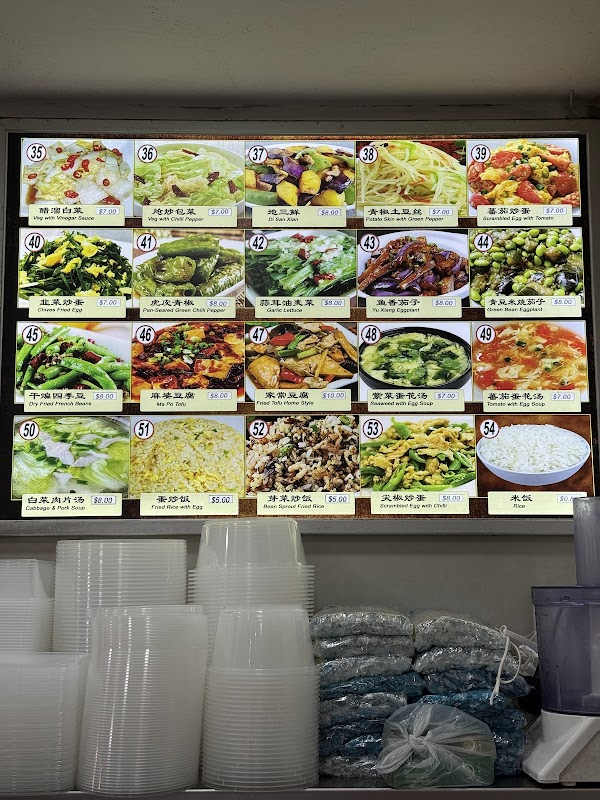

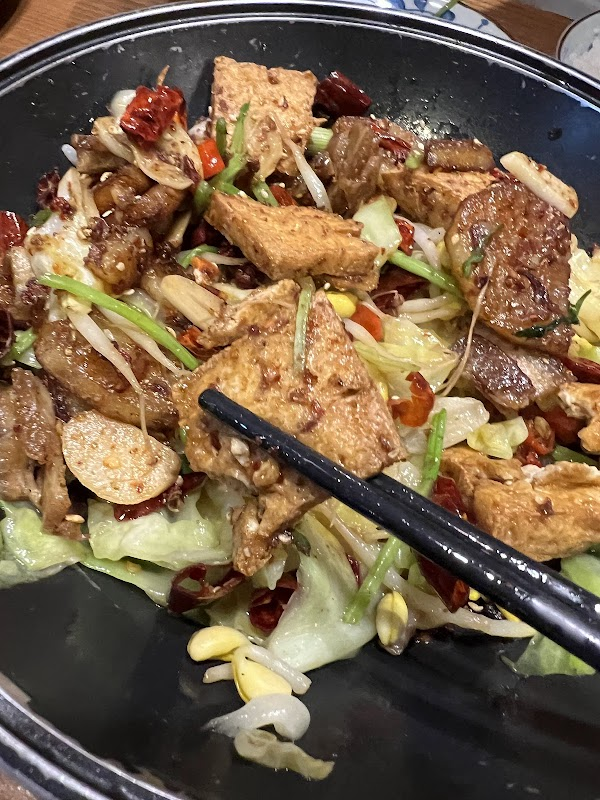

In [5]:
# 交互输入
query = input("请输入要查找的餐厅名称：").strip()
if not query:
    query = "Din Tai Fung Jewel Changi"  # 留个默认，防止空回车

show_restaurant_photos(
    query,
    region_code="SG",          # 需要可选国家/地区再加一个 input() 即可
    top_places=1,
    photos_per_place=4,
    max_w=800, max_h=800
)